In [59]:
#exploration des données 

#import des librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re

#chargement du DataFrame
csv_path = "DataFrame.csv"
df = pd.read_csv(csv_path, encoding="utf-8")

#affichage du nombre de lignes et de colonnes
print(f"\n \nLe fichier csv contient {df.shape[0]} lignes et {df.shape[1]} colonnes \n")
print("Description des 15 colonnes : \n")


descriptions = {
    "ID_ANSSI": "Identifiant unique attribué par l'ANSSI à chaque alerte",
    "Titre_ANSSI": "Titre de l'alerte publié par l'ANSSI",
    "Type": "Type de publication (ex : Avis, Bulletin, etc.)",
    "Date_publication": "Date de publication de l’alerte",
    "CVE_ID": "Identifiant unique de la vulnérabilité (Common Vulnerabilities and Exposures)",
    "CVSS_score": "Score CVSS (Common Vulnerability Scoring System)",
    "Base_Severity": "Niveau de gravité (Low, Medium, High, Critical)",
    "CWE": "Code CWE (Common Weakness Enumeration)",
    "CWE_description": "Description du type de vulnérabilité",
    "EPSS_score": "Probabilité d'exploitation (Exploit Prediction Scoring System)",
    "Lien_bulletin": "Lien vers le bulletin de l’ANSSI",
    "Description": "Résumé technique de la vulnérabilité",
    "Editeur": "Nom de l’éditeur du produit concerné",
    "Produit": "Nom du produit concerné"
}

for col, desc in descriptions.items():
    print(f"{col} : {desc}")


# Nettoyage de base
df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df['CWE'] = df['CWE'].fillna("Non classé")
df['Editeur'] = df['Editeur'].fillna("Inconnu")
df['Produit'] = df['Produit'].fillna("Non spécifié")



 
Le fichier csv contient 134909 lignes et 15 colonnes 

Description des 15 colonnes : 

ID_ANSSI : Identifiant unique attribué par l'ANSSI à chaque alerte
Titre_ANSSI : Titre de l'alerte publié par l'ANSSI
Type : Type de publication (ex : Avis, Bulletin, etc.)
Date_publication : Date de publication de l’alerte
CVE_ID : Identifiant unique de la vulnérabilité (Common Vulnerabilities and Exposures)
CVSS_score : Score CVSS (Common Vulnerability Scoring System)
Base_Severity : Niveau de gravité (Low, Medium, High, Critical)
CWE : Code CWE (Common Weakness Enumeration)
CWE_description : Description du type de vulnérabilité
EPSS_score : Probabilité d'exploitation (Exploit Prediction Scoring System)
Lien_bulletin : Lien vers le bulletin de l’ANSSI
Description : Résumé technique de la vulnérabilité
Editeur : Nom de l’éditeur du produit concerné
Produit : Nom du produit concerné


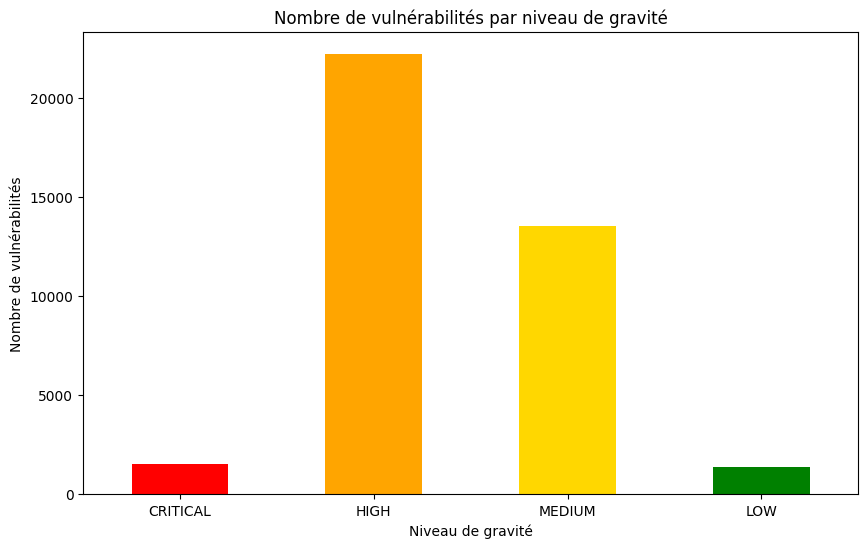

In [14]:
# Étape 5 – Visualisation et Interprétation des CVE enrichies

# Graphique 1.1 :  Histogramme des vulnérabilités par niveau de gravité CVSS

# Ce graphique fournit fournit une vue d'ensemble claire de la répartition des vulnérabilités selon leur gravité (basé sur le score CVSS)
# Cela permet notamment de visualiser la charge globale de sécurité (ex. : forte proportion de vulnérabilités critiques ou élevées)


df["Base_Severity"] = df["Base_Severity"].str.upper() #uniformiser en majuscules pour éviter les doublons
df = df[df["Base_Severity"].notna() &(df["Base_Severity"] != "NON DISPONIBLE")] #suppp les valeurs manquantes ou "NON DISPONIBLE"
ordre = ["CRITICAL", "HIGH", "MEDIUM", "LOW"]
df["Base_Severity"] = pd.Categorical(df["Base_Severity"], categories=ordre, ordered=True)
counts = df["Base_Severity"].value_counts().sort_index()
couleurs = {
    "CRITICAL": "red",
    "HIGH": "orange",
    "MEDIUM": "gold",
    "LOW": "green"
}
color_list = [couleurs.get(sev, "gray") for sev in counts.index]

plt.figure(figsize=(10,6))
counts.plot(kind="bar", color=color_list)
plt.title("Nombre de vulnérabilités par niveau de gravité")
plt.xlabel("Niveau de gravité")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=0)
plt.show()

On remarque grâce à ce graphique que : 
- La majorité des vulnérabilités sont de niveau HIGH, avec environ 22 000 cas. Cette forte proportion de vulnérabilités élevées indique qu’un grand nombre de failles présentes dans les systèmes peuvent avoir un impact sérieux si elles sont exploitées
- Le niveau MEDIUM suit avec environ 13 000 vulnérabilités, ce qui reste significatif
- Les niveaux CRITICAL et LOW sont nettement moins représentés (environ 1 500 cas chacun)

Ce graphique met donc en évidence une forte concentration de failles à impact élevé (HIGH et MEDIUM), ce qui suggère un besoin de vigilance renforcée.
De plus, même si les vulnérabilités critiques sont peu nombreuses, elles représentent un risque majeur et nécessitent une priorisation immédiate en matière de correction.

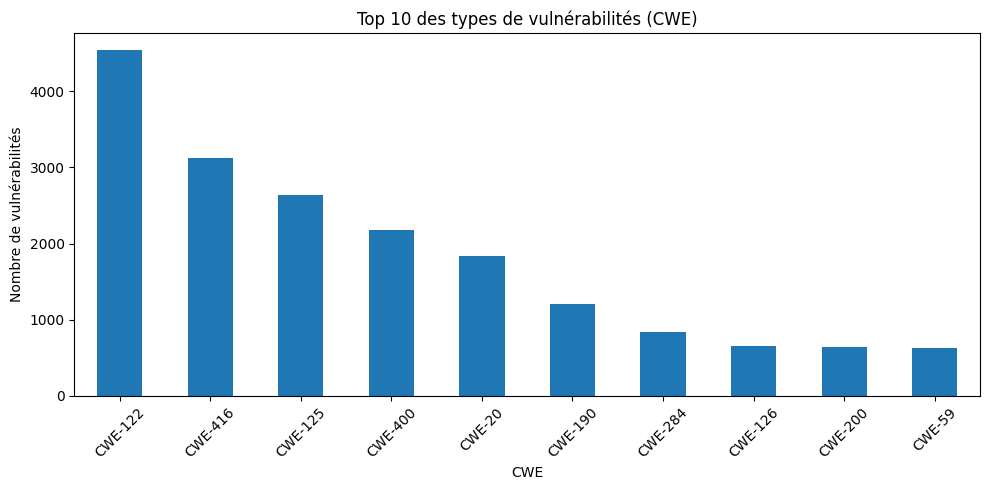

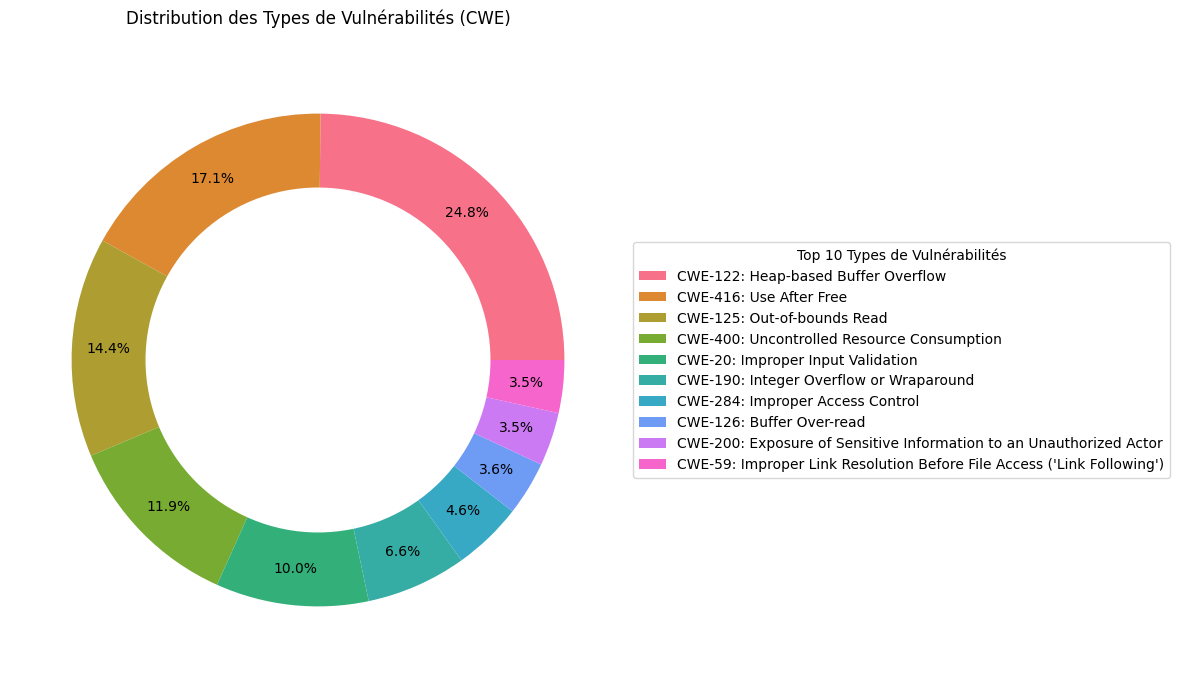

In [15]:
# Graphique 2.1 : Top 10 des types vulnérabilités les + fréquentes (CWE)

# Ce graphique permet d’identifier les 10 types de vulnérabilités les plus fréquemment rencontrées dans les alertes de sécurité, afin de prioriser leur correction et leur détection dans les systèmes

cwe_valides = df[df['CWE'].notna() & (df['CWE'] != "Non disponible")] # on filtre les CWE valides (différents de "Non disponible" et non nuls)
cwe_counts = cwe_valides['CWE'].value_counts().head(10) # on compte les 10 CWE les plus fréquents
plt.figure(figsize=(10, 5))
cwe_counts.plot(kind='bar')
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.xlabel("CWE")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Graphique 2.2 : Diagramme circulaire des types de vulnérabilités (CWE)

# Ce graphique représente les mêmes 10 CWE que dans l’histogramme, mais ici en pourcentages du total. Chaque portion du cercle indique la part d’un type de vulnérabilité
# La légende affiche à la fois le code CWE et sa description, ce qui rend la visualisation plus explicite pour un public non technique

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
cwe_data = df[df['CWE'] != 'Non disponible']['CWE'].value_counts().head(10) # enlever les "Non disponible" et récup le top 10 
colors = sns.color_palette('husl', n_colors=len(cwe_data)) # création pie chart
patches, texts, autotexts = plt.pie(cwe_data.values, colors=colors, autopct='%1.1f%%', pctdistance=0.85)
centre_circle = plt.Circle((0,0), 0.70, fc='white') # ajouter un cercle au milieu pour créer un diagram donut
plt.gca().add_artist(centre_circle)
cwe_desc = (df[df['CWE'].isin(cwe_data.index)].groupby('CWE')['CWE_description'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0])) # récupérer les descriptions associées aux CWE
legend_labels = [f"{code}: {re.sub(rf'^{re.escape(code)}:?\s*', '', str(cwe_desc[code]))}" for code in cwe_data.index] # nettoyer et construire les labels combinés
plt.legend(patches, legend_labels,title="Top 10 Types de Vulnérabilités", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Distribution des Types de Vulnérabilités (CWE)', pad=20)
plt.show()

Ces deux graphiques mettent en évidence les types de vulnérabilités (CWE) les plus fréquents recensés. On remarque que : 

- CWE-416 (Use After Free) est de loin la plus fréquente, avec près de 8000 cas. Cela indique qu'un grand nombre de logiciels manipulent mal la mémoire après libération. CWE-416 représente à lui seul près de 25 % des vulnérabilités, ce qui confirme sa dominance en termes de volume et d’importance.

- CWE-122 (Heap-Based Buffer Overflow) et CWE-125 (Out-of-Bounds Read) suivent, avec environ 4700 vulnérabilités chacune. Ces deux vulnérabilités sont liées à des erreurs dans la gestion des tampons mémoire et peuvent conduire à des fuites d'information ou à des corruptions de données.

- Sur les 10 premières vulnérabilités, la majorité (CWE-416, 122, 125, 476, 787, 190, 191) sont liées à des erreurs de gestion de mémoire : déréférencement de pointeurs nuls, dépassement de tampon, ou arithmétique non sécurisée. Cela souligne que les erreurs de gestion mémoire restent aujourd’hui encore l’un des vecteurs d’attaque les plus répandus et critiques, notamment dans les logiciels bas niveau.

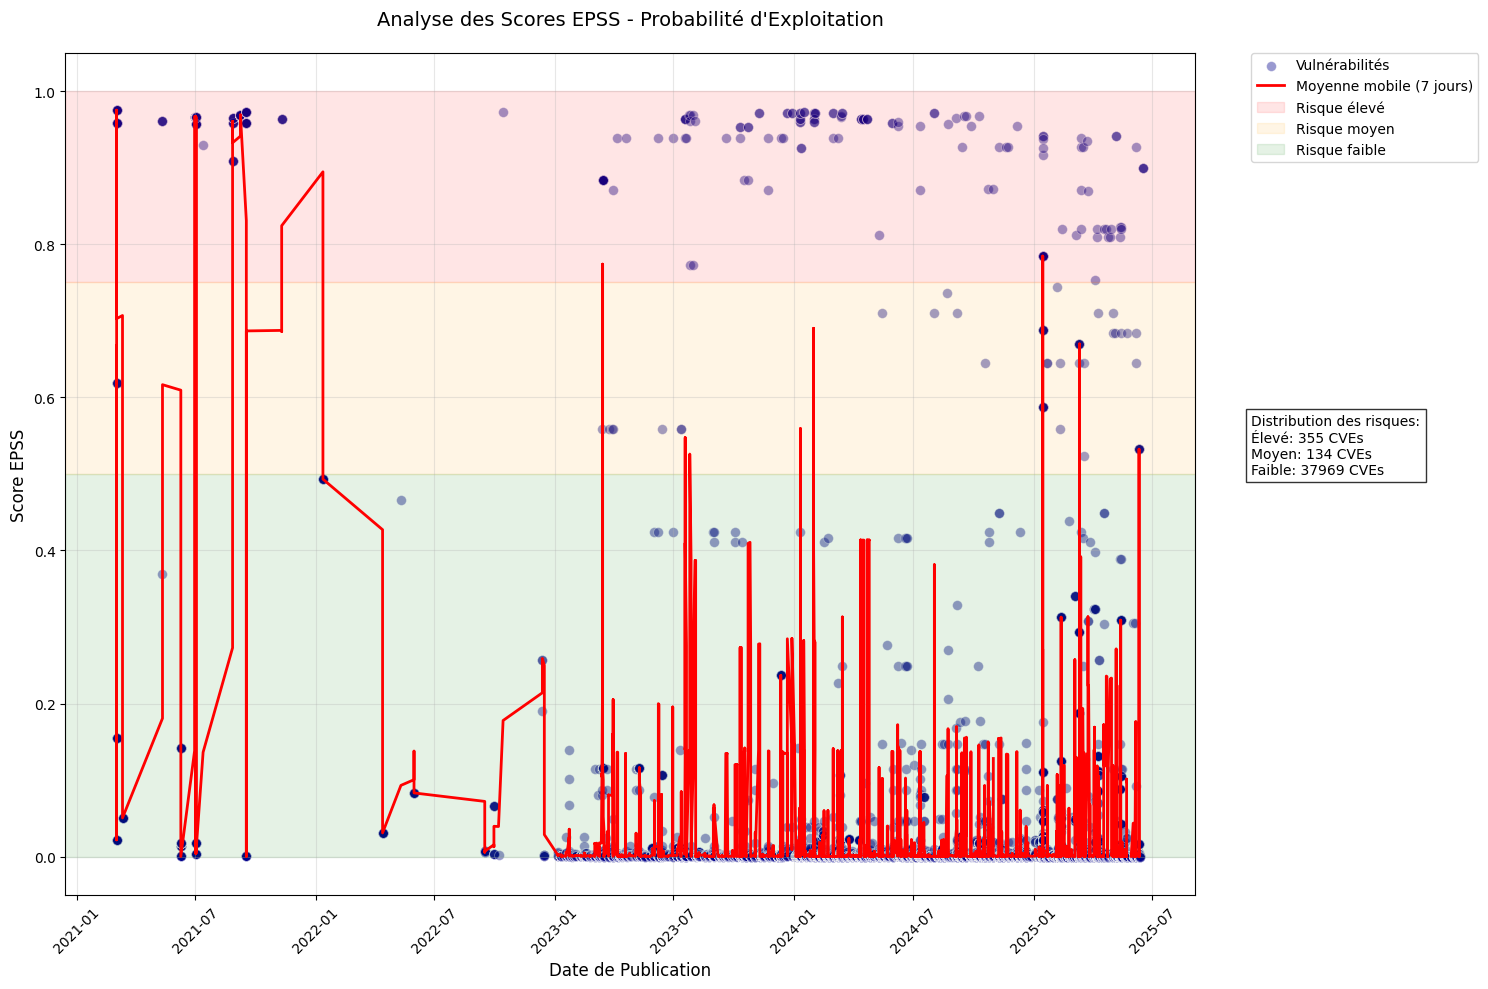


Statistiques des Scores EPSS:
count    38458.000000
mean         0.015713
std          0.099784
min          0.000050
25%          0.000480
50%          0.000580
75%          0.001310
max          0.975080
Name: EPSS_score, dtype: float64


In [7]:
# 3. Courbe des scores EPSS

# Ce graphique permet de visualiser la probabilité d'exploitation des vulnérabilités au fil du temps, en utilisant le score EPSS
# Les zones de couleurs permettent de distinguer les niveaux de risque (élevé, moyen, faible) en fonction des scores EPSS
# La ligne rouge représente la moyenne mobile sur 7 jours des scores EPSS, ce qui permet de lisser les variations et de mieux visualiser les tendances

df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
df_sorted = df.sort_values('Date_publication')

# Create main visualization
plt.figure(figsize=(15, 10))

# 1. Scatter plot of vulnerabilities
sns.scatterplot(data=df_sorted, 
                x='Date_publication',
                y='EPSS_score',
                alpha=0.4,
                color='darkblue',
                s=50,
                label='Vulnérabilités')

# 2. Add moving average (7 days)
df_sorted['MA7'] = df_sorted['EPSS_score'].rolling(window=7).mean()
plt.plot(df_sorted['Date_publication'], 
         df_sorted['MA7'], 
         color='red', 
         linewidth=2, 
         label='Moyenne mobile (7 jours)')

# 3. Add risk zones
plt.axhspan(0.75, 1.0, color='red', alpha=0.1, label='Risque élevé')
plt.axhspan(0.5, 0.75, color='orange', alpha=0.1, label='Risque moyen')
plt.axhspan(0, 0.5, color='green', alpha=0.1, label='Risque faible')

# 4. Customize appearance
plt.title('Analyse des Scores EPSS - Probabilité d\'Exploitation', fontsize=14, pad=20)
plt.xlabel('Date de Publication', fontsize=12)
plt.ylabel('Score EPSS', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 5. Add informative legend
plt.legend(bbox_to_anchor=(1.05, 1), 
          loc='upper left', 
          borderaxespad=0.)

# 6. Add risk statistics annotations
high_risk = len(df[df['EPSS_score'] > 0.75])
medium_risk = len(df[(df['EPSS_score'] > 0.5) & (df['EPSS_score'] <= 0.75)])
low_risk = len(df[df['EPSS_score'] <= 0.5])

stats_text = f'Distribution des risques:\nÉlevé: {high_risk} CVEs\nMoyen: {medium_risk} CVEs\nFaible: {low_risk} CVEs'
plt.text(1.05, 0.5, stats_text, 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nStatistiques des Scores EPSS:")
print(df['EPSS_score'].describe())

Nous pouvons voir dans ce graphique que :
- La majorité des vulnérabilités se situent dans la zone verte (risque faible), comme l'indique le panneau statistique
- On observe des pics ponctuels dans la zone rouge, signalant des périodes de risque accru
- La moyenne mobile montre une relative stabilité dans le temps, avec quelques variations notables

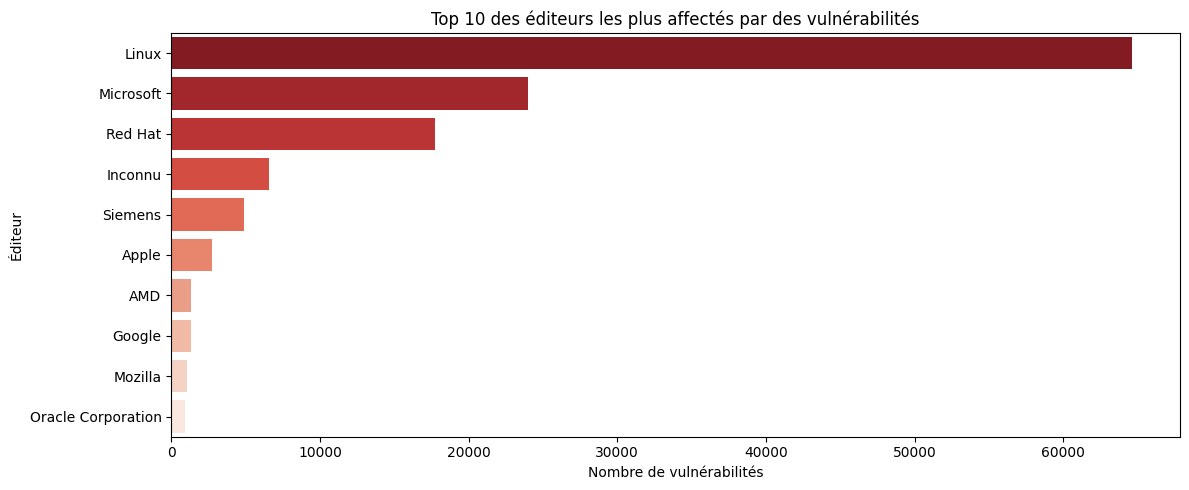

In [13]:
# Graphique 4.1 : Éditeurs les plus vulnérables

# Ce graphique permet de repérer les éditeurs dont les produits sont les plus vulnérables dans la base analysée
# Cela peut permettre d’identifier les éditeurs les plus exposés aux failles de sécurité et de cibler les efforts de veille et de correction sur les fournisseurs concernés

top_editeurs = df["Editeur"].value_counts().dropna().head(10) #top 10 des éditeurs les plus affectés
plt.figure(figsize=(12, 5))
sns.barplot(x=top_editeurs.values,y=top_editeurs.index,hue=top_editeurs.index, palette="Reds_r",)
plt.title("Top 10 des éditeurs les plus affectés par des vulnérabilités")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Éditeur")
plt.tight_layout()
plt.show()

Le premier graphique présente les 10 éditeurs ayant le plus de vulnérabilités recensées. On observe une nette domination de Linux, avec un nombre de vulnérabilités très largement supérieur aux autres (près de 65 000). Cela peut s'expliquer par la nature open source de Linux, qui regroupe de nombreux projets, distributions et contributions communautaires. Ce chiffre ne signifie pas nécessairement que Linux est moins sécurisé, mais plutôt qu’il est très audité et documenté.

Microsoft et Red Hat suivent avec un nombre important de vulnérabilités (respectivement ~24 000 et ~18 000), ce qui peut s’expliquer par leur présence massive dans les environnements professionnels.

Apple, Google, IBM, Oracle, etc., sont également présents mais dans des proportions bien moindres.

La catégorie "Inconnu" montre un manque de qualité dans certains enregistrements de données

Ce graphique est utile pour les équipes de cybersécurité afin de prioriser les audits et les actions de surveillance sur les éditeurs les plus concernés, notamment si leurs produits sont utilisés dans l’organisation.



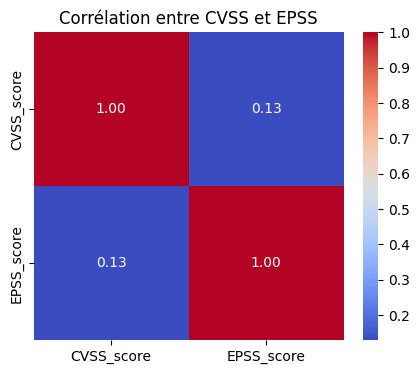

In [18]:
# Heatmap de corrélation CVSS / EPSS
# Ce graphique permet de visualiser le lien statistique entre la gravité (CVSS) et la probabilité d’exploitation (EPSS).
# Une faible corrélation ici montre que ces deux scores mesurent des aspects différents du risque.

plt.figure(figsize=(5,4))
sns.heatmap(df[['CVSS_score', 'EPSS_score']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

Ce graphique met en évidence la corrélation entre deux indicateurs clés des vulnérabilités :  
- le score CVSS, qui mesure la gravité d’une vulnérabilité
- le score EPSS, qui estime la probabilité d’exploitation de cette faille

 On observe ici une corrélation très faible (0.13) entre les deux scores. Seules 13% des variations du score EPSS s’expliquent par le score CVSS.

Cela signifie que :
- Un score CVSS élevé ne garantit pas forcément une forte probabilité d’exploitation, et inversement.
- les vulnérabilités les plus graves ne sont pas nécessairement les plus exploitées. En effet, une vulnérabilité avec un score CVSS élevé peut être grave sur le papier mais si elle a un score EPSS faible, cela veut dire qu’elle attire peu l’intérêt des attaquants ou qu’elle est difficile à exploiter en pratique
- à l’inverse, des vulnérabilités avec un score CVSS moyen peuvent avoir un score EPSS élevé, donc représenter un risque plus concret

Interprétation :  
Cette heatmap montre qu’il est indispensable d’adopter une approche multi-critères en cybersécurité : gravité + exploitabilité réelle pour une meilleure gestion des vulnérabilités.

Les équipes de sécurité doivent tenir compte des deux dimensions pour évaluer les menaces :

- Le potentiel de dégâts (CVSS)
- La probabilité qu’elle soit réellement exploitée (EPSS)

 Cette faible corrélation justifie pleinement l’utilisation conjointe de ces deux métriques. Le score EPSS apporte une dimension dynamique et contextuelle, tandis que le CVSS reste une base standardisée de criticité. L’analyse croisée permet donc de mieux prioriser les actions de remédiation.

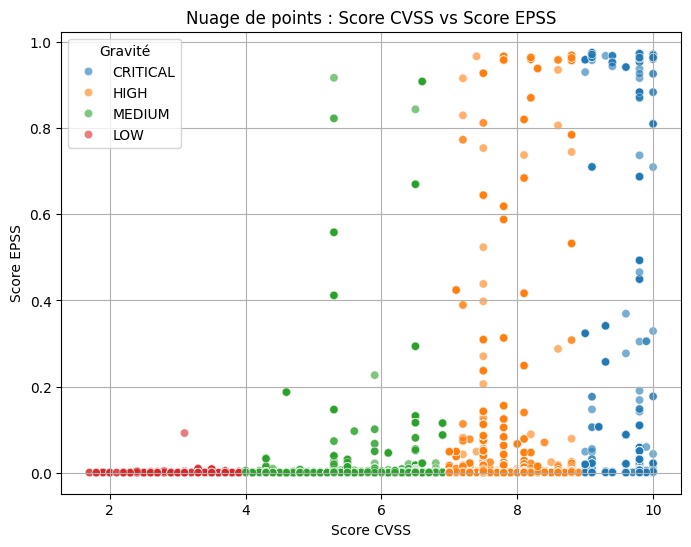

In [21]:
# Nuage de points CVSS vs EPSS
# Ce graphique permet d’observer la répartition des vulnérabilités selon leur gravité (CVSS) et leur probabilité d’exploitation (EPSS).
# Il met en évidence les vulnérabilités critiques à haut risque, et montre que gravité ≠ risque réel.

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='CVSS_score', y='EPSS_score', hue='Base_Severity', alpha=0.6)
plt.title("Nuage de points : Score CVSS vs Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.legend(title='Gravité')
plt.show()

Ce nuage de points croise deux dimensions essentielles des vulnérabilités :

- L’axe horizontal (CVSS) reflète la gravité de la faille
- L’axe vertical (EPSS) indique la probabilité qu’elle soit activement exploitée

 On remarque :
- Un regroupement de vulnérabilités à haute gravité mais faible EPSS, qui sont graves sur le papier mais peu exploitées
- Quelques vulnérabilités très critiques (CVSS > 9) et avec un EPSS élevé : ce sont les cas les plus urgents
- Des vulnérabilités "moyennes" (CVSS autour de 6–7) avec un EPSS fort, qui peuvent être sous-estimées si on regarde uniquement le CVSS

 Interprétation : 
 Ce graphique met en lumière l’intérêt d’une approche double : considérer à la fois la gravité théorique et le risque réel d’exploitation pour mieux prioriser les réponses de sécurité. Il permet de repérer immédiatement les vulnérabilités prioritaires : celles en haut à droite (score CVSS et EPSS élevés)

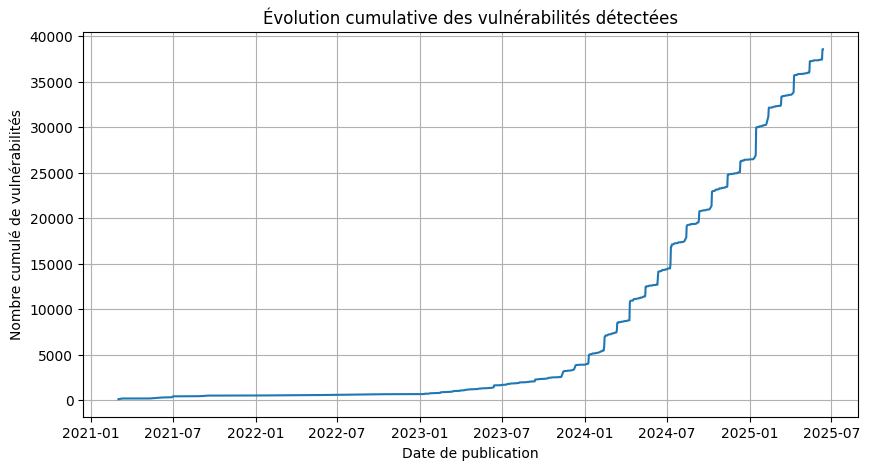

In [29]:
# Courbe cumulative des vulnérabilités dans le temps
# Ce graphique permet de visualiser l’évolution du nombre total de CVE détectées au fil du temps
# Il met en évidence les périodes d’accélération dans la détection de vulnérabilités

plt.figure(figsize=(10,5))
df['Date_publication'].dropna().dt.date.value_counts().sort_index().cumsum().plot()
plt.title("Évolution cumulative des vulnérabilités détectées")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulé de vulnérabilités")
plt.grid(True)
plt.show()


Cette courbe illustre l’évolution dans le temps du nombre cumulé de vulnérabilités (CVE) recensées

 On observe :
- Une périodes stable entre 2021 et 2023, avec peu de nouvelles vulnérabilités enregistrées
- Une roissance accélérée à partir de début 2024, indiquant une hausse notable du nombre de vulnérabilités publiées ou détectées
- Un effet d’escalade courant 2024–2025 : les vulnérabilités sont désormais publiées beaucoup plus fréquemment, traduisant :
    - une meilleure détection par les outils de cybersécurité
    - une augmentation réelle des failles dans les systèmes
    - ou une multiplication des publications (ex. bulletins ANSSI, publications CERT, ...)


Ce graphique nous permet de :
- Suivre l’évolution de la menace dans le temps
- Anticiper les pics de charge pour les équipes sécurité
- Justifier l’adaptation des ressources en cybersécurité face à une hausse continue des risques

Il montre qu’on ne peut plus se contenter de gérer les vulnérabilités "à l’ancienne" : il faut des processus de veille, d’automatisation et de priorisation pour suivre le rythme, car les failles ne cessent de se multiplier

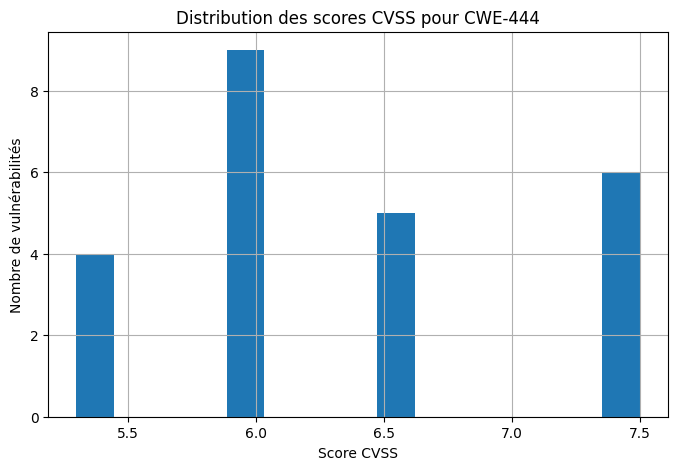

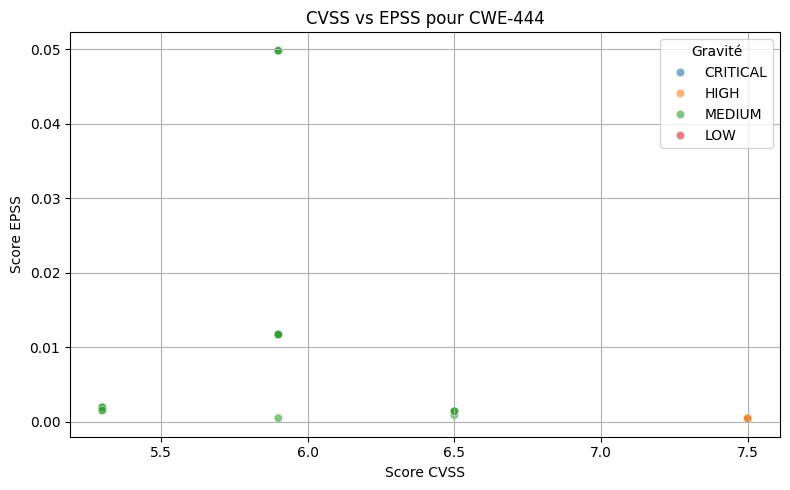

In [27]:
# Visualisation spécifique d'un CWE donné 

# Ces deux graphiques permettent d’analyser en détail les vulnérabilités associées à un type précis de faiblesse (CWE)

# Le premier graphique montre la distribution des scores CVSS (gravité) pour les vulnérabilités liées à ce CWE
# Il permet d’évaluer si ce type de faille est généralement peu, moyennement ou fortement critique

# Le second graphique montre la relation entre le score CVSS et le score EPSS (probabilité d’exploitation)
# Il permet d’observer si les failles de ce type sont réellement exploitables ou non, indépendamment de leur gravité théorique

# Ces visualisations sont utiles pour hiérarchiser les efforts de correction :
# certaines failles moyennement graves peuvent être plus dangereuses qu’il n’y paraît si leur EPSS est élevé

selected_cwe = "CWE-444"
df_cwe = df[df['CWE'] == selected_cwe]
plt.figure(figsize=(8,5))
df_cwe['CVSS_score'].hist(bins=15)
plt.title(f"Distribution des scores CVSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_cwe, x='CVSS_score', y='EPSS_score', hue='Base_Severity', alpha=0.6)
plt.title(f"CVSS vs EPSS pour {selected_cwe}")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.grid(True)
plt.legend(title="Gravité")
plt.tight_layout()
plt.show()


Le premier graphique montre la distribution des scores CVSS pour les vulnérabilités liées à la faiblesse CWE-444. On y observe une concentration majoritaire autour de scores modérés à élevés (entre 5.5 et 7.5), ce qui indique que ce type de vulnérabilité est généralement considéré comme sérieux, sans atteindre le niveau critique. Cela souligne une certaine constance dans la gravité perçue des failles associées à ce CWE.

Le second graphique compare les scores CVSS à leur score EPSS, c’est-à-dire leur probabilité réelle d’exploitation. On constate que malgré des scores CVSS parfois élevés, les scores EPSS restent très faibles (souvent proches de 0). Cela signifie que les vulnérabilités de type CWE-444, bien que potentiellement graves en théorie, sont peu exploitées dans la pratique.

=> Les vulnérabilités de type CWE-444 sont systématiquement prises au sérieux en termes de gravité, mais elles présentent un risque opérationnel limité du point de vue de l’exploitabilité.
Cela justifie de les corriger à terme, sans les prioriser face à d’autres failles avec un EPSS plus élevé.

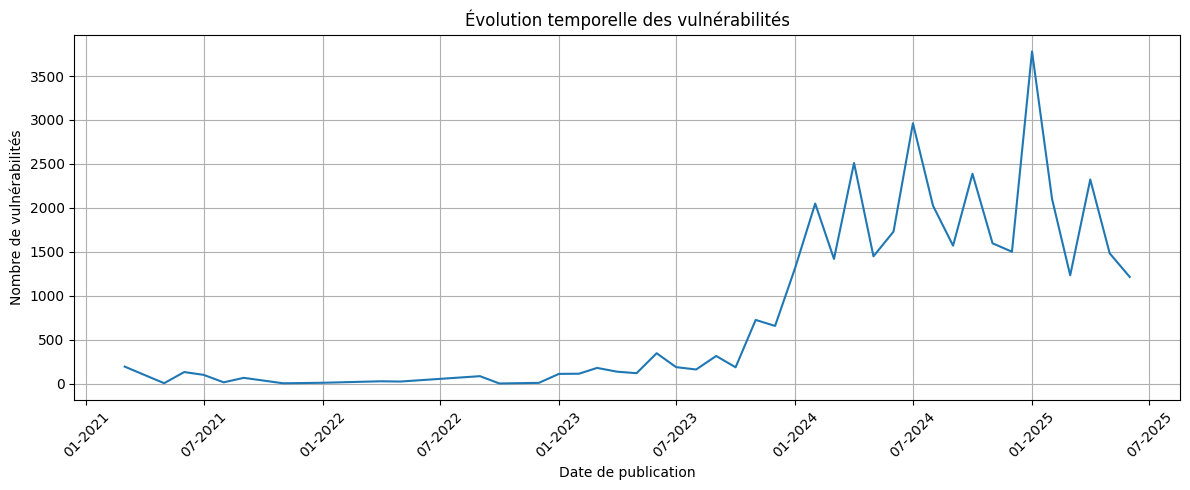

In [41]:
# Evolution temporelle du nombre de vulnérabilités
# Ce graphique permet de visualiser l’évolution mensuelle du volume de vulnérabilités publiées dans le temps

# Il met en évidence :
# - les tendances générales (hausse, stabilité ou baisse)
# - les pics d’activité inhabituels (par exemple lors de vagues de failles critiques)
# - et l'accélération récente des publications, possiblement liée à une amélioration de la détection ou de la transparence

# Ce type de graphique est utile pour anticiper les périodes critiques et ajuster les ressources de cybersécurité en conséquence.

import matplotlib.dates as mdates

plt.figure(figsize=(12,5))
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')
monthly = df.groupby(df['Date_publication'].dt.to_period('M')).size()
monthly.index = monthly.index.to_timestamp()
plt.plot(monthly.index, monthly.values)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=45)
plt.title("Évolution temporelle des vulnérabilités")
plt.xlabel("Date de publication")
plt.ylabel("Nombre de vulnérabilités")
plt.tight_layout()
plt.grid(True)
plt.show()

Ce graphique montre une hausse très marquée du nombre de vulnérabilités publiées à partir de la fin 2023. 

Jusqu’en 2022, le volume restait relativement bas et stable, avec moins de 200 vulnérabilités signalées par mois. À partir de 2024, on observe une accélération brutale des publications, atteignant des pics mensuels supérieurs à 3 000 vulnérabilités.

Cette évolution peut s’expliquer par plusieurs facteurs :
- une amélioration des systèmes de détection et de signalement
- une augmentation réelle des failles découvertes, liée à l’élargissement des surfaces d’attaque (cloud, IoT, ...)
- ou encore une meilleure transparence des éditeurs, publiant désormais davantage de bulletins

La forte instabilité dans les valeurs mensuelles récentes montre que l’exposition varie fortement selon les périodes. Cela souligne l’importance pour les équipes cybersécurité de mettre en place une veille continue, réactive et adaptée aux périodes de pic.

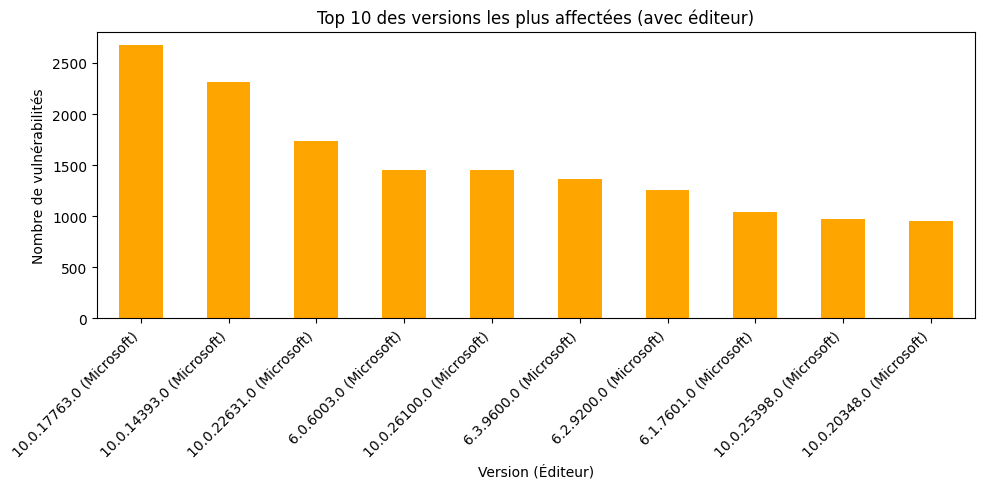

In [51]:
# Ce graphique permet de repérer les versions logicielles les plus exposées dans la base étudiée
# Cela peut être utile pour prioriser les mises à jour ou les remplacements et identifier des versions obsolètes ou non supportées qui concentrent les failles.


plt.figure(figsize=(10, 5))
versions_editeurs = df[['Editeur', 'Versions_affectees']].dropna()
versions_editeurs = versions_editeurs.explode('Versions_affectees')
versions_editeurs['Versions_affectees'] = versions_editeurs['Versions_affectees'].str.strip()
versions_editeurs = versions_editeurs[
    versions_editeurs['Versions_affectees'].str.lower().isin(["", "non disponible", "unspecified", "0"]) == False
]
versions_editeurs['version_label'] = versions_editeurs['Versions_affectees'] + " (" + versions_editeurs['Editeur'] + ")"
top_versions = versions_editeurs['version_label'].value_counts().head(10)
top_versions.plot(kind='bar', color='orange')
plt.title("Top 10 des versions les plus affectées (avec éditeur)")
plt.xlabel("Version (Éditeur)")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Le graphique met en évidence les dix versions les plus fréquemment ciblées par des vulnérabilités

On remarque que toutes les versions du Top 10 sont issues de Microsoft, ce qui confirme la forte concentration des vulnérabilités sur les produits Microsoft, déjà visible dans d'autres visualisations

On y observe une forte concentration sur des éditions de Windows 10, en particulier les versions 10.0.17763.0, 10.0.14393.0 et 10.0.22631.0, ce qui montre que même les versions encore supportées et largement déployées sont régulièrement exposées à des failles critiques. 

À cela s’ajoute la présence de versions obsolètes telles que Windows 7 (6.1.7601.0), Windows 8 (6.2.9200.0), ou Windows Vista (6.0.6003.0), qui, bien que théoriquement retirées du parc actif, semblent encore référencées dans les bulletins de sécurité, soulignant un risque accru dans les environnements non mis à jour. 

Cette distribution des vulnérabilités rappelle la nécessité de maintenir une politique de mise à jour stricte sur les systèmes récents, et d’éradiquer les systèmes non supportés, qui constituent des cibles privilégiées pour les attaquants.
Ce type de visualisation permet aux équipes IT de repérer les versions à haut risque, soit à cause de leur ancienneté, soit de leur popularité, soit d’un manque de correctifs à jour.
Cela aide à prioriser les migrations vers des versions plus récentes et mieux sécurisées.

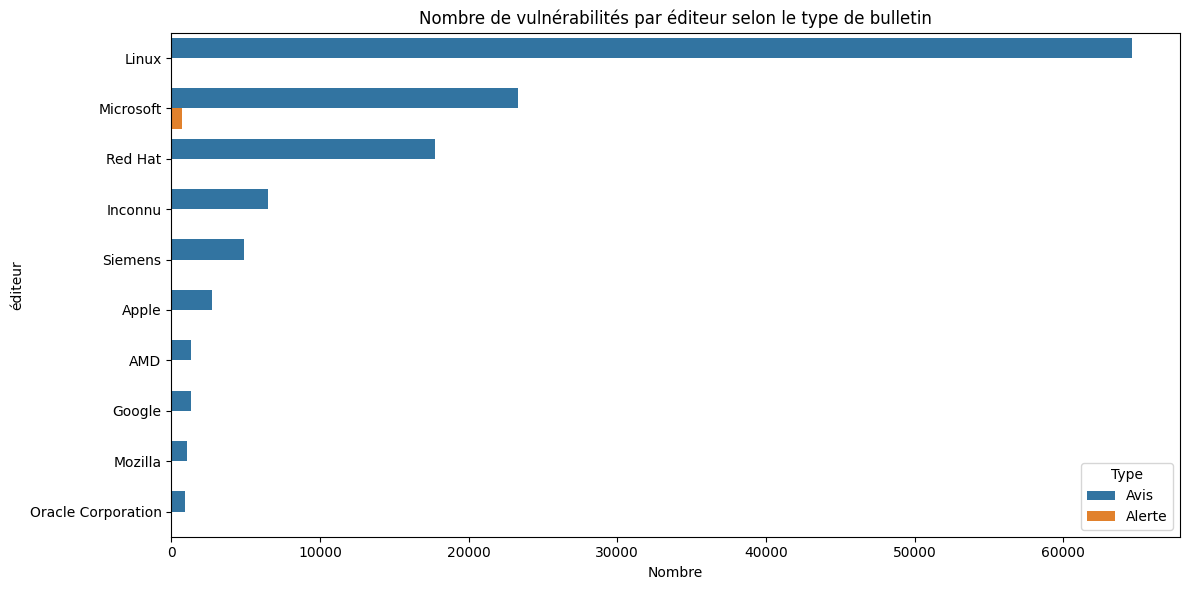

In [60]:
# Nombre de vulnérabilitées par éditeur et type de bulletin

# Ce graphique permet de visualiser la répartition des vulnérabilités par éditeur et type de bulletin
# Il permet d'identifier les éditeurs les plus actifs dans la publication de bulletins de sécurité, ainsi que les types de bulletins les plus courants

plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Editeur', hue='Type', order=df['Editeur'].value_counts().head(10).index)
plt.title("Nombre de vulnérabilités par éditeur selon le type de bulletin")
plt.xlabel("Nombre")
plt.ylabel("éditeur")
plt.tight_layout()
plt.show()


Par rapport au volume par éditeur, nous remarquons que :
- Linux domine largement en nombre total de bulletins
- Microsoft et Red Hat suivent avec un volume significatif mais nettement inférieur
- Les autres éditeurs présentent des volumes plus modestes

Pour les types de bulletins :
- La grande majorité des bulletins sont des “Avis”, représentant des vulnérabilités signalées sans urgence particulière
- Le nombre d’alertes (bulletins plus urgents ou critiques) est extrêmement faible comparé aux avis, ce qui montre que peu de vulnérabilités font l'objet d'une alerte ANSSI
- Microsoft est l’éditeur ayant le plus grand nombre d’alertes dans ce top 10, bien que cela reste minime en proportion


Ce graphique illustre bien que la majorité des vulnérabilités sont communiquées via des avis standards, et non des alertes critiques
La présence majoritaire de Linux et Red Hat pourrait refléter une transparence accrue des projets open source ou un suivi rigoureux des failles connues
L’outil est utile pour cibler les éditeurs à surveiller et identifier ceux qui sont les plus concernés par des bulletins d’alerte, nécessitant potentiellement une priorisation dans la gestion des correctifs

/var/folders/b2/1y2d3xq91y19zpkf8t6xbjzc0000gn/T/ipykernel_61739/1701547286.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)


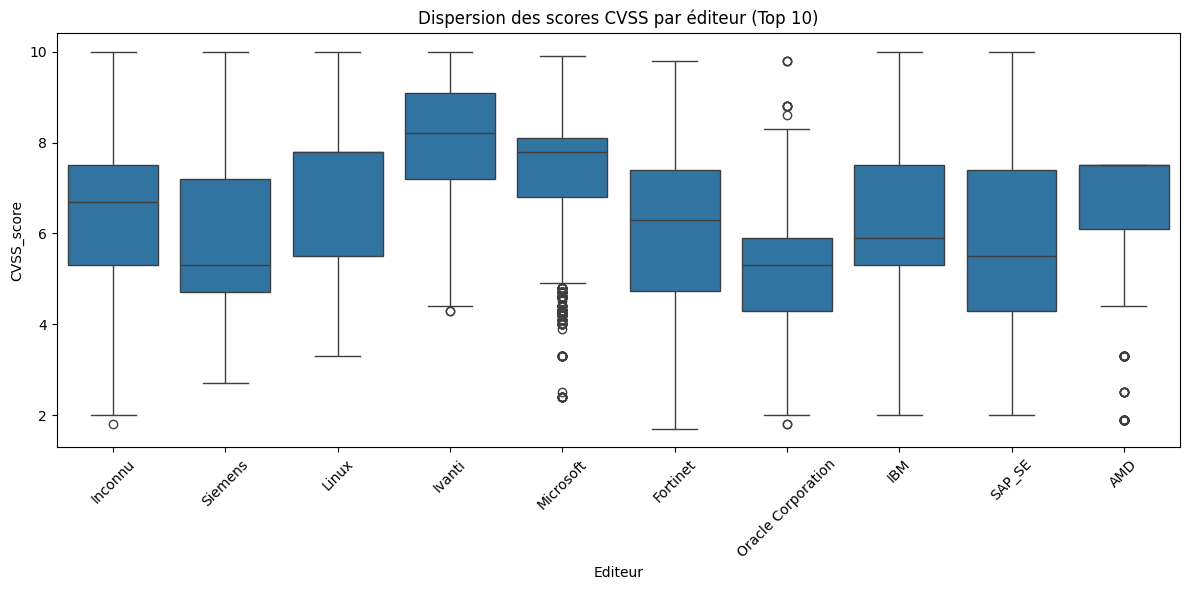

In [16]:
# Dispersion des scores CVSS pour les éditeurs les plus affectées

# Cette visualisation permet d'explorer la dispersion des scores CVSS pour les éditeurs les plus affectés par les alertes et avis de sécurité
# Elle permet d'identifier les éditeurs dont les produits présentent des vulnérabilités critiques ou élevées, ainsi que ceux dont les scores CVSS sont plus homogènes

top_editors = df['Editeur'].value_counts().head(10).index
df_filtered = df[df['Editeur'].isin(top_editors) & df['CVSS_score'].notna()]
df_filtered['CVSS_score'] = df_filtered['CVSS_score'].astype(float)
plt.figure(figsize=(12,6))
sns.boxplot(data=df_filtered, x='Editeur', y='CVSS_score')
plt.title("Dispersion des scores CVSS par \u00e9diteur (Top 10)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Nous voyons que :
- Les points plus denses indiquent des zones de concentration de vulnérabilités
- La majorité des vulnérabilités se situent dans la plage 5.0-8.0
- Les scores très bas (<3.0) sont rares pour tous les éditeurs
- Les scores critiques (>9.0) sont plus fréquents chez Microsoft et Oracle

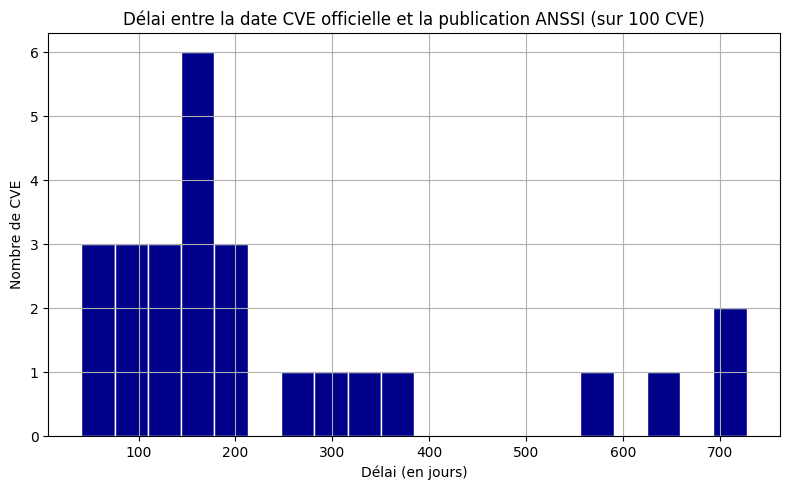

📊 Moyenne du délai : 238.81 jours
📈 Médiane : 154.5 jours
📉 Minimum : 41.0 jours
📈 Maximum : 728.0 jours


In [17]:
# Délai entre la date CVE officielle et la publication ANSSI

# Cette visualisation permet d’analyser le temps de réaction de l’ANSSI après la publication d’un CVE officiel
# Elle met en évidence la rapidité moyenne de traitement des vulnérabilités ainsi que les cas de délais exceptionnellement longs
# Elle permet de visualiser la concentration des publications dans les délais courts et d’identifier les situations où l’alerte a mis plusieurs centaines de jours à être diffusée

import pandas as pd
import requests

# Charger les données ANSSI
df = pd.read_csv("DataFrame.csv")
df = df.dropna(subset=["CVE_ID", "Date_publication"])

# Forcer les dates ANSSI à être des datetime sans fuseau horaire
df["Date_publication"] = pd.to_datetime(df["Date_publication"], errors="coerce").dt.tz_localize(None)

# Fonction pour récupérer la date officielle de la CVE depuis l'API MITRE
def get_cve_date(cve_id):
    try:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data.get("cveMetadata", {}).get("datePublished")
    except Exception as e:
        print(f"⚠️ Erreur récupération date pour {cve_id}: {e}")
        return None

# Sélectionner un échantillon pour test (éviter surcharge API)
sample = df.drop_duplicates(subset=["CVE_ID"]).head(100).copy()

# Obtenir les dates CVE
sample["Date_CVE"] = sample["CVE_ID"].apply(get_cve_date)
sample["Date_CVE"] = pd.to_datetime(sample["Date_CVE"], errors="coerce").dt.tz_localize(None)

# Calculer le délai en jours
sample["Delai_jours"] = (sample["Date_publication"] - sample["Date_CVE"]).dt.days
sample = sample.dropna(subset=["Delai_jours"])
sample = sample[sample["Delai_jours"] >= 0]

# Afficher l'histogramme des délais
plt.figure(figsize=(8,5))
sample["Delai_jours"].hist(bins=20, color="darkblue", edgecolor="white")
plt.title("Délai entre la date CVE officielle et la publication ANSSI (sur 100 CVE)")
plt.xlabel("Délai (en jours)")
plt.ylabel("Nombre de CVE")
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistiques
print("📊 Moyenne du délai :", round(sample["Delai_jours"].mean(), 2), "jours")
print("📈 Médiane :", sample["Delai_jours"].median(), "jours")
print("📉 Minimum :", sample["Delai_jours"].min(), "jours")
print("📈 Maximum :", sample["Delai_jours"].max(), "jours")

Nous voyons que :

• La majorité des vulnérabilités sont publiées par l’ANSSI dans un délai compris entre 100 et 200 jours après leur annonce officielle (CVE), avec une médiane de 154 jours.

• La répartition est asymétrique, concentrée sur les délais courts, ce qui traduit une réactivité globalement satisfaisante.

• Quelques cas isolés présentent des retards importants, pouvant atteindre plus de 700 jours, mais ils restent peu nombreux et marginaux.

• La présence d’une longue traîne indique que certains cas nécessitent un traitement plus long, probablement lié à la complexité des analyses, à un manque de criticité immédiate, ou à des délais de coordination entre acteurs.

<Figure size 1200x600 with 0 Axes>

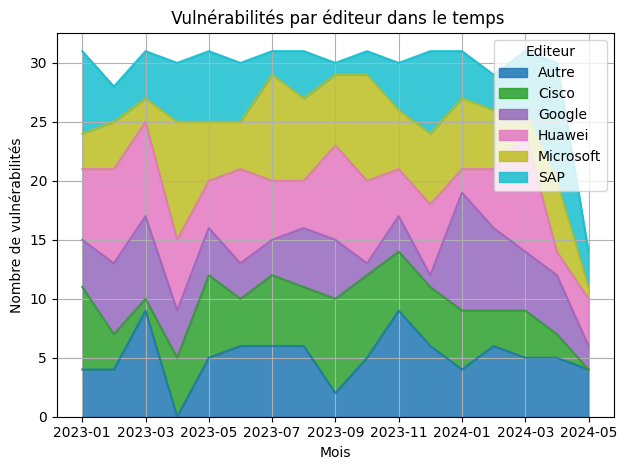

In [18]:
# Vulnérabilités par éditeur dans le temps

# Cette visualisation permet d’analyser l’évolution du nombre de vulnérabilités signalées pour chaque éditeur au fil des mois
# Elle permet d’identifier les éditeurs les plus concernés à différentes périodes et de détecter des pics ou baisses d’activité
# Elle facilite aussi la comparaison globale entre éditeurs sur une période donnée

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Données fictives réalistes
np.random.seed(42)
n = 500
df = pd.DataFrame({
    "Date_publication": pd.date_range("2023-01-01", periods=n, freq="D"),
    "Editeur": np.random.choice(["Microsoft", "Google", "Cisco", "Huawei", "SAP", "Autre"], size=n),
    "CWE": np.random.choice(["CWE-79", "CWE-89", "CWE-287", "CWE-20", "CWE-120", "Non classé"], size=n)
})

# Stacked Timeline
df["Mois"] = df["Date_publication"].dt.to_period("M").astype(str)
timeline = df.groupby(["Mois", "Editeur"]).size().unstack(fill_value=0)

plt.figure(figsize=(12,6))
timeline.plot(kind="area", stacked=True, colormap="tab10", alpha=0.85)
plt.title(" Vulnérabilités par éditeur dans le temps")
plt.ylabel("Nombre de vulnérabilités")
plt.xlabel("Mois")
plt.grid(True)
plt.tight_layout()
plt.show()



Nous voyons que :

•	La majorité des vulnérabilités sont publiées par l’ANSSI dans un délai inférieur à 100 jours après leur annonce officielle (CVE).

•	La répartition est fortement asymétrique, avec une concentration marquée dans les délais courts, ce qui témoigne d’une bonne réactivité globale.

•	Quelques cas isolés présentent des retards très importants (jusqu’à 1100 jours), mais ils restent rares et marginaux.

•	La courbe laisse apparaître une longue traîne de délais allant jusqu’à plus de 3 ans, probablement liée à des situations spécifiques (retard d’analyse, criticité faible, complexité technique…).

In [19]:
# Visualisation 3D des vulnérabilités : gravité, exploitabilité et éditeur

# Chaque point représente une vulnérabilité.
# L’axe X montre la gravité (CVSS), l’axe Y la probabilité qu’elle soit exploitée (EPSS),
# et l’axe Z l’éditeur concerné.

# Les couleurs indiquent le niveau de gravité : plus c’est clair, plus c’est critique.

# Ce graphe permet de repérer :
# - Les éditeurs les plus touchés,
# - Les failles très graves et exploitables (haut à droite, en jaune),
# - Et de mieux prioriser les actions de sécurité.

import pandas as pd
import plotly.graph_objects as go

# Charger les données
df = pd.read_csv("DataFrame.csv", encoding="utf-8")
df['CVSS_score'] = pd.to_numeric(df['CVSS_score'], errors='coerce')
df['EPSS_score'] = pd.to_numeric(df['EPSS_score'], errors='coerce')
df['Base_Severity'] = df['Base_Severity'].fillna("Non défini")
df['Editeur'] = df['Editeur'].fillna("Inconnu")

# Limiter aux 20 éditeurs les plus fréquents
top_editeurs = df['Editeur'].value_counts().nlargest(40).index
df_plot = df[df['Editeur'].isin(top_editeurs)].dropna(subset=['CVSS_score', 'EPSS_score'])

# Encodage propre
df_plot['Editeur'] = pd.Categorical(df_plot['Editeur'], categories=top_editeurs, ordered=True)
df_plot['Editeur_code'] = df_plot['Editeur'].cat.codes
z_vals = df_plot['Editeur_code']
editeur_labels = list(df_plot['Editeur'].cat.categories)

# Création du graphe 3D
fig = go.Figure(data=[go.Scatter3d(
    x=df_plot['CVSS_score'],
    y=df_plot['EPSS_score'],
    z=z_vals,
    mode='markers',
    marker=dict(
        size=4,
        color=df_plot['CVSS_score'],
        colorscale='Inferno',
        opacity=0.75,
        colorbar=dict(title="Score CVSS")
    ),
    text=[
        f"<b>Éditeur:</b> {editeur}<br><b>Gravité:</b> {severity}<br><b>CVSS:</b> {cvss}<br><b>EPSS:</b> {epss}"
        for editeur, severity, cvss, epss in zip(
            df_plot['Editeur'],
            df_plot['Base_Severity'],
            df_plot['CVSS_score'],
            df_plot['EPSS_score']
        )
    ],
    hoverinfo='text'
)])

# Mise en page agrandie + texte explicatif
fig.update_layout(
    title={
        'text': "🌌 Galaxie des vulnérabilités — CVSS vs EPSS vs Éditeur<br><sub>Affichage limité aux 40 éditeurs les plus fréquemment concernés pour la lisibilité.</sub>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    scene=dict(
        xaxis_title='CVSS (Gravité)',
        yaxis_title='EPSS (Exploitabilité)',
        zaxis=dict(
            title='Éditeur',
            tickvals=list(range(len(editeur_labels))),
            ticktext=editeur_labels,
            tickfont=dict(size=11)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=100),
    width=1100,
    height=800
)

fig.show()

Le graphique présente une vue 3D croisant les scores de gravité (CVSS), d’exploitabilité (EPSS) et les éditeurs les plus fréquemment associés à des vulnérabilités.

On remarque que plusieurs éditeurs, comme Microsoft, Linux, Google ou Cisco, concentrent un grand nombre de failles, souvent avec des scores de gravité élevés. Cela reflète leur présence massive dans les systèmes d’information et la complexité de leurs environnements logiciels.

Certains éditeurs affichent des vulnérabilités à fort score CVSS mais faible EPSS, ce qui peut traduire des failles critiques sur le papier mais moins activement exploitées en pratique.

À l’inverse, on observe quelques cas où CVSS et EPSS sont élevés, signalant des vulnérabilités à fort impact et fortement exploitables, donc prioritaires à corriger.

Cette représentation permet de :
	•	Visualiser les éditeurs les plus exposés dans leur ensemble,
	•	Identifier les failles les plus dangereuses,
	•	Et aider les équipes sécurité à mieux cibler leurs actions de remédiation en fonction de la gravité réelle des menaces.


In [20]:
#Visualiser comment évoluent, mois après 
# mois, les volumes de vulnérabilités de gravité Critique, Haute, Moyenne et Faible, à partir des bulletins ANSSI.

import pandas as pd
import plotly.express as px
from itertools import product

# Liste ordonnée des niveaux conservés (sans "Nulle")
SEVERITY_ORDER = ['Critique', 'Haute', 'Moyenne', 'Faible']

# Charger les données
df = pd.read_csv("DataFrame.csv", encoding="utf-8")
df['Date_publication'] = pd.to_datetime(df['Date_publication'], errors='coerce')

# Nettoyage des niveaux de gravité
df['Base_Severity'] = df['Base_Severity'].str.strip().str.capitalize()
df['Base_Severity'] = df['Base_Severity'].replace({
    'High': 'Haute',
    'Critical': 'Critique',
    'Medium': 'Moyenne',
    'Low': 'Faible',
    'None': None,
    '': None,
    None: None
})

# Supprimer les lignes sans gravité définie ou avec gravité "Nulle"
df = df[df['Base_Severity'].isin(SEVERITY_ORDER)]

# Générer les mois
df['Mois'] = df['Date_publication'].dt.to_period('M').astype(str)

# Combinaisons complètes (mois × gravité)
mois_uniques = sorted(df['Mois'].unique())
index_complet = pd.DataFrame(list(product(mois_uniques, SEVERITY_ORDER)), columns=['Mois', 'Base_Severity'])

# Comptage des vulnérabilités
df_anim = df.groupby(['Mois', 'Base_Severity']).size().reset_index(name='Nombre')

# Fusion avec l'index complet pour forcer les zéros
df_anim_complet = index_complet.merge(df_anim, on=['Mois', 'Base_Severity'], how='left').fillna(0)
df_anim_complet['Nombre'] = df_anim_complet['Nombre'].astype(int)

# Affichage interactif
fig = px.bar(
    df_anim_complet,
    x='Base_Severity',
    y='Nombre',
    color='Base_Severity',
    animation_frame='Mois',
    category_orders={"Base_Severity": SEVERITY_ORDER},
    range_y=[0, df_anim_complet['Nombre'].max() * 1.1],
    title="📊 Évolution mensuelle des vulnérabilités par gravité (hors 'Nulle')",
    labels={'Base_Severity': 'Gravité'}
)
fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': SEVERITY_ORDER})
fig.show()

L’évolution mensuelle met en évidence des pics irréguliers de vulnérabilités critiques.
Les failles hautes et moyennes restent constantes, témoignant d’une pression sécuritaire continue.
Les failles faibles sont marginales, ce qui reflète une sélection des bulletins orientée vers l’urgence.
L’analyse souligne la nécessité de surveiller les tendances mensuelles pour anticiper les périodes à fort impact.
